In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries
Always run this cell

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats
from skimage.io import imread, imshow
from skimage import data, filters, measure, morphology
from skimage.measure import label, regionprops, regionprops_table
from matplotlib.colors import ListedColormap

# Find your project directory

In [ ]:
# this notebook directory
notebook_path = 'ansci_344'
# your sound directory
image_files = 'image_files'
# ouput directory
image_plots = 'image_plots'

directory = os.path.join(notebook_path, image_files)
output_dir = os.path.join(notebook_path, image_plots)
if not os.path.exists(output_dir):
  os.mkdir(output_dir)
# ----------
assert os.path.exists(notebook_path), f"The notebook_path: <{notebook_path}> does not exist\nverify that the path is correct"
assert os.path.exists(directory), f"The audio files location: <{directory}> does not exist\nverify that the path is correct"
assert len(os.listdir(directory)) > 0, f"The <{sound_files}> folder is empty, make sure that you have uploaded your files"
print("Perfect!")

Perfect!


## Open Image

In [4]:
# put the name of the image you wan to read
image_filename = "example_image.png"
img_path = os.path.join(directory, image_filename)
image = imread(img_path)

## Get image dimensions

In [5]:
image_size = image.shape
print(f"Dimension 1: {image_size[0]},\nDimension 2: {image_size[1]}, \nDimension 3: {image_size[2]}")

Dimension 1: 480,
Dimension 2: 640, 
Dimension 3: 3


# Image histogram for each RGB channel

1. Run the the histogam cells with the default theshold
2. Identify the best lower and upper bound for each channel
3. Modify the upper and lower thresholds for each channel

```
# ======== threshold ============
# ===============================
red_lower = 120
red_upper = 255
# ===============================
```
4. Run the histogram cells again
5. Repeat if you think you need to adjust the thresholds

In [6]:
def plot_ch_hist(ch_data, thres_low, thres_up, color_name):
  fig, axs = plt.subplots(figsize=(10, 5))
  axs.hist(ch_data, bins=256, range=[0, 256], facecolor= color_name)
  axs.set(title = f'{color_name} channel histogram', xlabel = 'Pixel value')
  axs.axvline(x = thres_low, color = 'black', linestyle='--')
  axs.axvline(x = thres_up, color = 'black', linestyle=':')
  return fig

In [7]:
red_channel = image[:,:,0]
green_channel = image[:,:,1]
blue_channel = image[:,:,2]

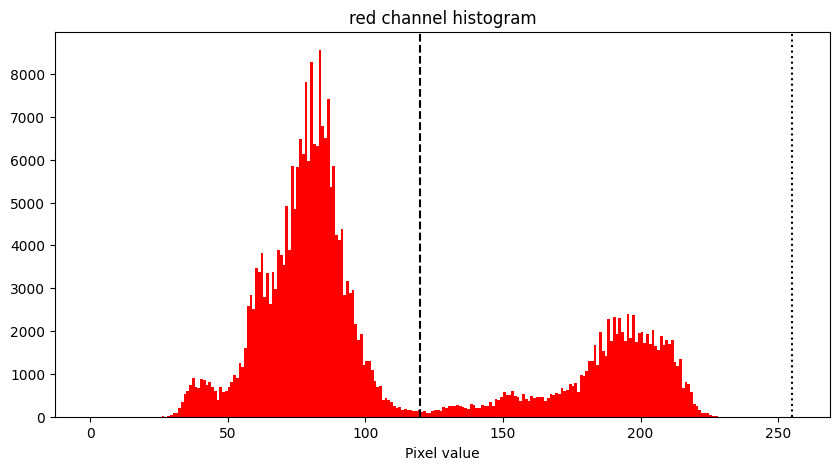

In [8]:
# ======== threshold ============
# ===============================
red_lower = 120
red_upper = 255
# ===============================
color_name =  "red"
hist_plot = plot_ch_hist(red_channel.flatten(), red_lower, red_upper, color_name)
hist_plot.savefig(os.path.join(output_dir, f"{color_name}_histogram.png"))


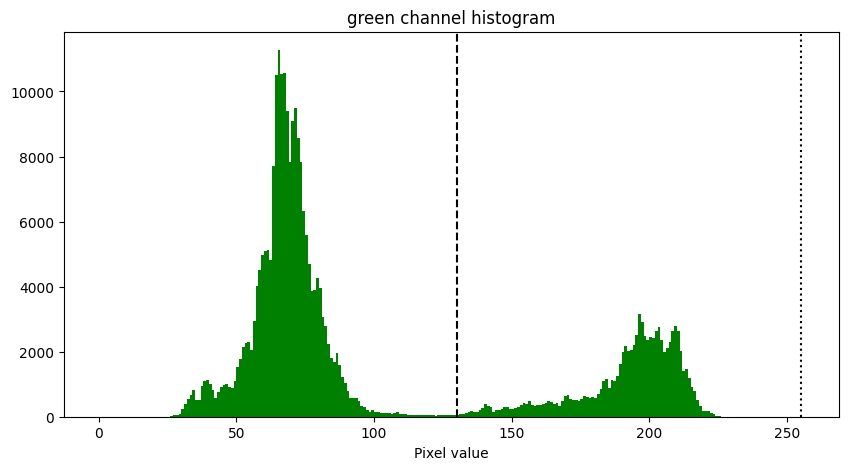

In [9]:
# ======== threshold ============
# ===============================
green_lower = 130
green_upper = 255
# ===============================
color_name =  "green"
hist_plot = plot_ch_hist(green_channel.flatten(), green_lower,green_upper, color_name)
hist_plot.savefig(os.path.join(output_dir, f"{color_name}_histogram.png"))

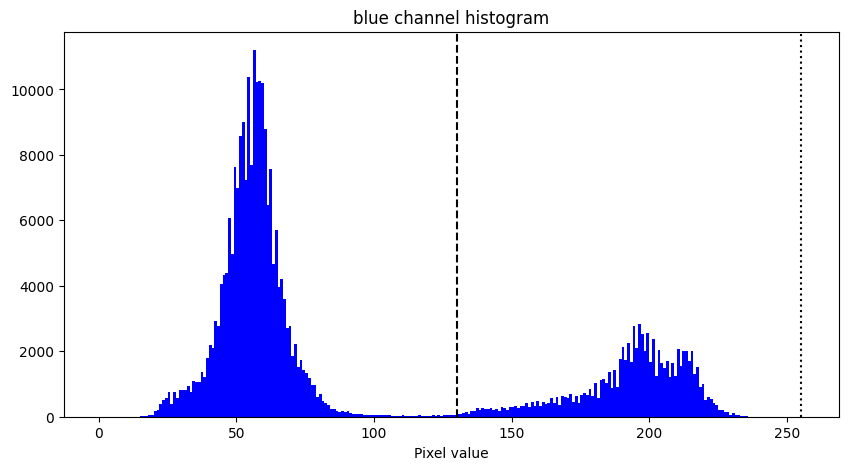

In [10]:
# ======== threshold ============
# ===============================
blue_lower = 120
blue_upper = 255
# ===============================
color_name =  "blue"
hist_plot = plot_ch_hist(blue_channel.flatten(), green_lower,green_upper, color_name)
hist_plot.savefig(os.path.join(output_dir, f"{color_name}_histogram.png"))

# Image segmentation

## Segmentation based on thresholds

In [11]:
#using all channels
mask = (red_channel >= red_lower) & (red_channel <= red_upper) & \
       (green_channel >= green_lower) & (green_channel <= green_upper) & \
       (blue_channel >= blue_lower) & (blue_channel <= blue_upper)
# Set to 0 all pixels that are outside the defined bounds
rc = red_channel.copy()
rc[np.invert(mask)] = 0
gc = green_channel.copy()
gc[np.invert(mask)] = 0
bc = blue_channel.copy()
bc[np.invert(mask)] = 0

# Recombine separate color channels into a single, true color RGB image
segmented_image = np.stack((rc, gc, bc), axis=-1)

## Visualizing the original and segmented images

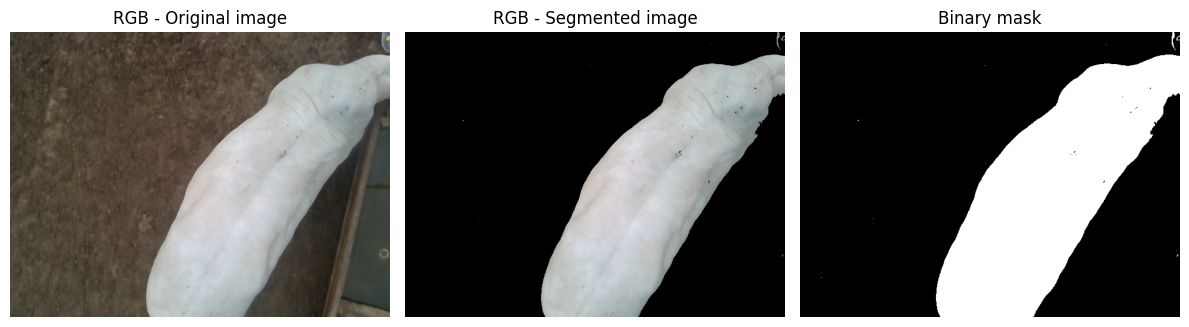

In [12]:
image_name = image_filename.split(".")[0]
fig, axs = plt.subplots(nrows= 1, ncols = 3, figsize=(12, 5))
axs[0].imshow(image)
axs[0].set(title = 'RGB - Original image')
axs[0].axis('off')
axs[1].imshow(segmented_image)
axs[1].set(title = 'RGB - Segmented image')
axs[1].axis('off')
axs[2].imshow(mask, cmap='gray')
axs[2].set(title = 'Binary mask')
axs[2].axis('off')
plt.tight_layout()
fig.savefig(os.path.join(output_dir, f"{image_name}_segmentation.png"))


# Feature extraction

In [13]:
binaryImage = mask
label_image = label(binaryImage)
props = regionprops_table(label_image, properties=('centroid','area'))
props1 = pd.DataFrame(props)
area_list = props1.area
# remove small objects
area_thres = np.max(area_list)-1
binaryImage2 = morphology.remove_small_objects(binaryImage, area_thres)
label_image = label(binaryImage2)
props = regionprops_table(label_image, properties=('centroid','perimeter','area', 'eccentricity'))
props2 = pd.DataFrame(props)
props2

,centroid-0,centroid-1,perimeter,area,eccentricity
0,264.722778,423.01044,1503.888527,88218.0,0.938743


## Show features on image



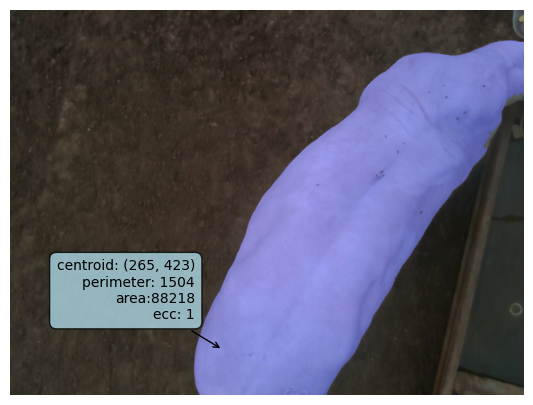

In [16]:
xc = props2.loc[0,"centroid-0"]
yc = props2.loc[0,"centroid-1"]
perimc = props2.loc[0,"perimeter"]
areac = props2.loc[0,"area"]
ecc =  props2.loc[0,"eccentricity"]
label = f"centroid: ({xc:.0f}, {yc:.0f})\nperimeter: {perimc:.0f}\narea:{areac:.0f}\necc: {ecc:.0f}"
mask2 = binaryImage2.copy()

cmp=ListedColormap(['black','blue'])
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(image)
axs.imshow(mask2, alpha= 0.3, cmap = cmp)
axs.axis('off')
# add centroid and annotations
axs.annotate(label,
      xy=(xc, yc), xytext=(-20, 20),
      textcoords='offset points', ha='right', va='bottom',
      bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.8),
      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
fig.savefig(os.path.join(output_dir, f"{image_name}_features.png"))